# Industrial Applications of Artificial Intelligence - Bias in Finance

### This notebook is part of the third hand-in regarding the secondary sector in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

Credit decisions, personal potential evaluation or support in judgements. Machine Learning algorithms are touching more and more areas of people's personal lives. However, this is not always benefitial. A sensation has been caused in 2016 by the publication of ProPublica about the software COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) that should help in discovering the underlying risk of a criminal becoming a recidivist [[1]](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). The authors found out that the algorithm is highly biased towards black people such that "black defendants are far more likely than white defendants to be incorrectly judged to be at a higher risk of recidivism" [[2]](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). This impressively illustrates that if developers and designers are not careful, human bias is picked up by algorithms leading to highly unfair results. Therefore, one has to be especially cautious involving personal sensitive data, for example sex, political attitude or religious affiliation. In the following notebook, we explore the influence of sensitive information in the case of income prediction and investigate how sensitive data can influence the decision.

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer

## I. Data Exploration

The dataset can be found on kaggle unter the following [URL](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset).  It was published by the Center for Machine Learning and Intelligent Systems of the University of California and the original dataset can be found under the following [link](http://www.cs.toronto.edu/~delve/data/adult/desc.html). The task is modelled as a binary classification to predicct if an individual's income excceds $50,000 based on data from the US Census Bureau. We want to explore if sensitive information does have an influence on the result and compare it to the case, when some information are discarded.
First of all, the dataset consists out of 48,842 entries containing 14 features and one target targets, which will be described in the following. We are not given a test set such that we have to create a split in the course of the work.
* age: Integer indicating the age of a person.
* workclass: Categorical variable indicating the employment status of a person.
* fnlwgt: Integer without further description. Nearly unique value per row, so might be kind of an identifier that may need to be discarded.
* education: Categorical variable indicating the highest degree of a person. 
* educational-num: Integer indicating the number of years spent on education.
* marital-status: Categorical variable indicating the marriage status.
* occupation: Categorical variable that indicates the employment type that a person has. 
* relationship: Categorical variable indicating the relationship status.
* race: Categorical variable indicating the race.
* gender: Binary variable that indicates wether a person is male or female.
* capital-gain: Integer indicating if a person has capital gains.
* capital-loss: Integer indicating if a person has capital losses.
* hours-per-week: Integer indicating how much hours a person works per week
* native-country: Categorical variable indicating the native-country of a person.
* income: Target. Binary variable that indicates wether a person has more than 50k income or not.

In [5]:
dir_path ='../../src/data/Abgabe_3/'

In [6]:
df = pd.read_csv(os.path.join(dir_path, "adult.csv"))
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [14]:
# look at distribution
df.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,48842.00,38.64,13.71,17.00,28.00,37.00,48.00,90.00
fnlwgt,48842.00,189664.13,105604.03,12285.00,117550.50,178144.50,237642.00,1490400.00
educational-num,48842.00,10.08,2.57,1.00,9.00,10.00,12.00,16.00
capital-gain,48842.00,1079.07,7452.02,0.00,0.00,0.00,0.00,99999.00
capital-loss,48842.00,87.50,403.00,0.00,0.00,0.00,0.00,4356.00
hours-per-week,48842.00,40.42,12.39,1.00,40.00,40.00,45.00,99.00


We can clearly see that we have highly critical features inside our data: race and gender. On top of that the native-country and the workclass could have an influence as well. If an algorithm would be totally objective, neither of the variables would have any influence on the result. That means the distribution of income should not differ wether a person is male or female or he/she belongs to a different race. As a first step, we explore the distribution of those variables and investigate if there are already obvious conspicuities.

In [16]:
df.groupby('gender').income.value_counts()

gender  income
Female  <=50K     14423
        >50K       1769
Male    <=50K     22732
        >50K       9918
Name: income, dtype: int64

In [17]:
df.groupby('race').income.value_counts()

race                income
Amer-Indian-Eskimo  <=50K       415
                    >50K         55
Asian-Pac-Islander  <=50K      1110
                    >50K        409
Black               <=50K      4119
                    >50K        566
Other               <=50K       356
                    >50K         50
White               <=50K     31155
                    >50K      10607
Name: income, dtype: int64

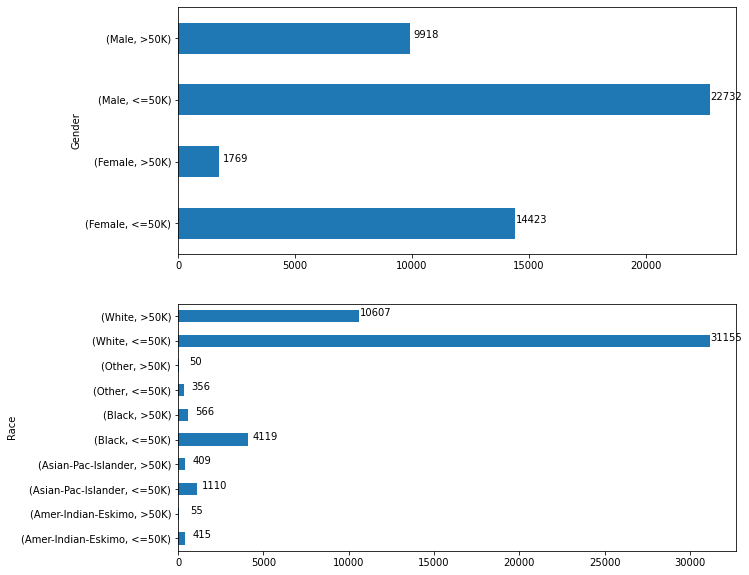

In [33]:
fig, (ax, ax2) = plt.subplots(2, 1,  figsize=(10,10))

df.groupby('gender').income.value_counts().plot(kind='barh',ax=ax)
ax.set_ylabel('Gender')
[ax.text(v+700, i, '{:}'.format(v), horizontalalignment='center') for i, v in enumerate(df.groupby('gender').income.value_counts())]
df.groupby('race').income.value_counts().plot(kind='barh',ax=ax2)
ax2.set_ylabel('Race')
[ax2.text(v+1000, i, '{:}'.format(v), horizontalalignment='center') for i, v in enumerate(df.groupby('race').income.value_counts())]
plt.show()

We can see that there is already a difference in the distribution towards women having less income than men. In the case of the race feature it is also obvious that the distributions differ a lot and white people having higher income, which looks a lot like bias. 

We gonna investigate right now, if the distributions of the numerical variables differ a lot for the gender and if that could be a possible explanation for the differences for the minority feature. For this reason, we split the dataset based on the feature and have a look at the other variables.

In [36]:
# Male
df_male = df[df['gender'] == 'Male']
#Female
df_female = df[df['gender'] == 'Female']

In [37]:
# look at distribution
df_male.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,32650.00,39.49,13.41,17.00,29.00,38.00,48.00,90.00
fnlwgt,32650.00,191727.02,106709.38,13492.00,117963.00,180138.00,241722.50,1490400.00
educational-num,32650.00,10.09,2.66,1.00,9.00,10.00,13.00,16.00
capital-gain,32650.00,1326.21,8367.78,0.00,0.00,0.00,0.00,99999.00
capital-loss,32650.00,100.41,430.22,0.00,0.00,0.00,0.00,3770.00
hours-per-week,32650.00,42.42,12.12,1.00,40.00,40.00,48.00,99.00


In [38]:
# look at distribution
df_female.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,16192.00,36.93,14.14,17.00,25.00,35.00,46.00,90.00
fnlwgt,16192.00,185504.47,103217.15,12285.00,116560.00,175572.00,228609.25,1484705.00
educational-num,16192.00,10.04,2.38,1.00,9.00,10.00,12.00,16.00
capital-gain,16192.00,580.73,5094.23,0.00,0.00,0.00,0.00,99999.00
capital-loss,16192.00,61.48,340.11,0.00,0.00,0.00,0.00,4356.00
hours-per-week,16192.00,36.40,11.95,1.00,30.00,40.00,40.00,99.00


We see that in most cases the statistical propties of the features do not differ by a lot. However, there are two features that stand out: age and hours-per-week. It seems that women in the dataset are overal younger and work less. This might be a possible explanation. In contrast, years of education are higher, which should indicate that women earn more.

In the following, we investigate how good an algorithm is able to predict that and if the distributions may further change due to bias.

# Continue here.

# II. Preprocessing

In [13]:
df[df.fnlwgt==151910]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
44479,23,Private,151910,Bachelors,13,Never-married,Machine-op-inspct,Own-child,White,Female,0,1719,40,United-States,<=50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [10]:
df.fnlwgt.nunique()

28523

Before we use an algorithm on the data, we gonna preprocess the features for better usage. In a first step, we check the set for missing values and afterwards round all the numerical features on two decimal places.

In [40]:
df.isna().sum()

minority          0
sex               0
ZIP               0
rent              0
education         0
age               0
income            0
loan_size         0
payment_timing    0
year              0
job_stability     0
default           0
occupation        0
dtype: int64

In [41]:
df = df.round(decimals = 2)

We can see that in the whole set are no missing values, which could be expected, since the dataset is synthetically generated. Furthermore, we encode all the categorical variables. The binary target variable is encoded with 1 for true and 0 for false, while the remaining categorical variables ZIP and occupation are one-hot-encoded.

In [42]:
cleanup_nums = {"default": {True: 1, False: 0}}
df = df.replace(cleanup_nums)
df.head()

,minority,sex,ZIP,rent,education,age,income,loan_size,payment_timing,year,job_stability,default,occupation
0,1,0,MT04PA,1,57.23,36.05,205168.02,7600.29,3.30,0,3.02,1,MZ10CD
1,1,0,MT04PA,1,45.89,59.53,187530.41,5534.27,3.84,0,5.94,1,MZ10CD
2,1,0,MT04PA,1,46.78,67.34,196912.01,2009.90,2.06,0,2.19,1,MZ10CD
3,1,0,MT04PA,1,41.78,24.07,132911.65,3112.28,3.94,0,1.73,1,MZ10CD
4,1,0,MT04PA,1,41.74,47.50,161162.55,1372.08,3.71,0,0.88,1,MZ10CD


In [43]:
df = pd.get_dummies(df, columns=["ZIP", "occupation"])

In [44]:
df.head()

,minority,sex,rent,education,age,income,loan_size,payment_timing,year,job_stability,default,ZIP_MT01RA,ZIP_MT04PA,ZIP_MT12RA,ZIP_MT15PA,occupation_MZ01CD,occupation_MZ10CD,occupation_MZ11CD
0,1,0,1,57.23,36.05,205168.02,7600.29,3.30,0,3.02,1,0,1,0,0,0,1,0
1,1,0,1,45.89,59.53,187530.41,5534.27,3.84,0,5.94,1,0,1,0,0,0,1,0
2,1,0,1,46.78,67.34,196912.01,2009.90,2.06,0,2.19,1,0,1,0,0,0,1,0
3,1,0,1,41.78,24.07,132911.65,3112.28,3.94,0,1.73,1,0,1,0,0,0,1,0
4,1,0,1,41.74,47.50,161162.55,1372.08,3.71,0,0.88,1,0,1,0,0,0,1,0


To not always copy and paste those steps in further processing, we will define a function preprocessing.

In [47]:
def preprocessing(df:pd.DataFrame, dec :int, categ:list) -> pd.DataFrame:
    """
    Function preprocess the dataset
    :param df: general dataframe
    :param dec: number of decimal places to which rounding takes place
    :param categ: list of categorical columns to one-hot-encode
    :return: preprocessed dataframe
    """
    df = df.round(decimals = dec)

    cleanup_nums = {"default": {True: 1, False: 0}}
    df = df.replace(cleanup_nums)
    
    df = pd.get_dummies(df, columns=categ)

    return df

Since we are already given a test set, we create a train-validation split to check the hypothesis on in a next step.

# III. Train-Validation-Split

We spit therefore split our given data into 80% train and 20% val. Before we do that, we will have a short look on the distribution of our target to check for an imbalanced set.

<AxesSubplot:>

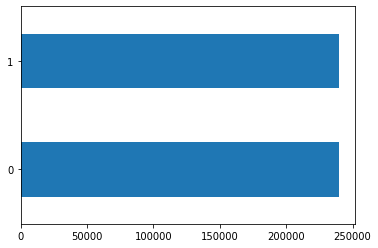

In [50]:
df['default'].value_counts().plot(kind ='barh')

We can clearly see that we have an balanced dataset and do not need to worry about a skewed distribution. We will also keep the test set completely out of all steps except the last predicition to see how the algorithms perform on the test set.

In [52]:
#  split up in train+val and test
data_train, data_val, target_train, target_val = train_test_split(df.drop(columns=['default']), df['default'], test_size=0.2, random_state=42, stratify=df['default'])

We will now have a look at the values in our different sets to check wether the distribution of the target is nearly the same.

In [53]:
# define values for plots
x = ['0','1']
y_train = target_train.value_counts().to_list()
y_val = target_val.value_counts().to_list()

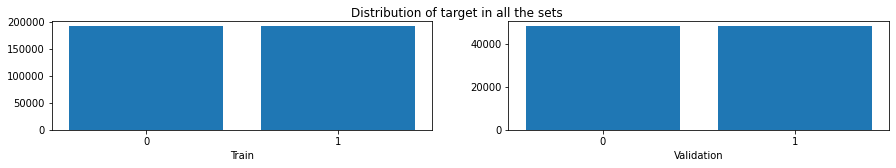

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(15,2))
fig.suptitle('Distribution of target in all the sets')
ax1.bar(x, y_train)
ax1.set_xlabel('Train')
ax2.bar(x, y_val)
ax2.set_xlabel('Validation')
plt.show()

We can clearly see that the distribution is nearly the same for all our sets. As we generated the train-test-validation split in the previous step, we now want to scale the data. Different scales might actually distort our algorithm a lot due to big differences in the scales. For scaling, we use the StandardScaler from the sklearn package. It should be noted that we only fit the scaler on our training data and use only the transformation on the validation and testing part, because we do not want to include information about validation and test that could already help the algorithm (data leakage).

In [57]:
df

,minority,sex,rent,education,age,income,loan_size,payment_timing,year,job_stability,default,ZIP_MT01RA,ZIP_MT04PA,ZIP_MT12RA,ZIP_MT15PA,occupation_MZ01CD,occupation_MZ10CD,occupation_MZ11CD
0,1,0,1,57.23,36.05,205168.02,7600.29,3.30,0,3.02,1,0,1,0,0,0,1,0
1,1,0,1,45.89,59.53,187530.41,5534.27,3.84,0,5.94,1,0,1,0,0,0,1,0
2,1,0,1,46.78,67.34,196912.01,2009.90,2.06,0,2.19,1,0,1,0,0,0,1,0
3,1,0,1,41.78,24.07,132911.65,3112.28,3.94,0,1.73,1,0,1,0,0,0,1,0
4,1,0,1,41.74,47.50,161162.55,1372.08,3.71,0,0.88,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479995,0,1,0,2.37,41.29,8815.71,5292.58,3.55,29,116.76,0,0,0,1,0,1,0,0
479996,0,1,0,1.50,65.68,6272.40,2891.87,1.11,29,98.04,0,0,0,1,0,1,0,0
479997,0,1,0,0.83,47.86,3228.16,9133.09,3.50,29,117.54,0,0,0,1,0,1,0,0
479998,0,1,0,0.68,47.14,2630.08,5000.25,3.66,29,103.06,0,0,0,1,0,1,0,0


In [58]:
# define standard scaler
scaler = StandardScaler()
# features to scale
numerical_features = ['education','age','income', 'loan_size','payment_timing','year','job_stability' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])

In [59]:
data_train.head(5)

,minority,sex,rent,education,age,income,loan_size,payment_timing,year,job_stability,ZIP_MT01RA,ZIP_MT04PA,ZIP_MT12RA,ZIP_MT15PA,occupation_MZ01CD,occupation_MZ10CD,occupation_MZ11CD
203880,1,1,1,-0.874053,-1.063913,-0.883947,-1.614102,-1.510953,1.213701,-0.964437,0,0,0,1,0,0,1
337472,1,1,1,-0.945320,1.092529,-0.923825,-0.430997,-0.220370,-0.289053,-0.999936,0,1,0,0,0,0,1
205255,0,1,0,-0.985637,0.876954,-0.969023,-0.760444,0.159802,1.213701,0.765055,1,0,0,0,1,0,0
48486,1,0,0,1.219148,-1.126298,0.955284,0.573513,0.960164,-0.982632,-0.994833,0,1,0,0,0,1,0
435919,1,1,1,-0.985637,1.667164,-0.965103,-0.593123,0.620010,1.098104,-1.017686,0,0,0,1,0,0,1


In [60]:
data_val.head(5)

,minority,sex,rent,education,age,income,loan_size,payment_timing,year,job_stability,ZIP_MT01RA,ZIP_MT04PA,ZIP_MT12RA,ZIP_MT15PA,occupation_MZ01CD,occupation_MZ10CD,occupation_MZ11CD
221555,0,1,0,-0.930252,1.028757,-0.908099,0.355498,0.920146,1.444894,0.848479,1,0,0,0,1,0,0
226678,1,0,1,0.864444,0.675242,0.993293,1.391549,0.589996,1.560490,-0.984849,0,0,0,1,0,1,0
270032,0,0,1,0.826571,1.114017,1.010440,1.194021,-1.180804,-1.329422,1.640562,0,0,1,0,1,0,0
44511,0,0,0,1.101864,-1.332861,0.783657,-0.037575,-1.140785,-1.098229,0.949209,1,0,0,0,1,0,0
60167,0,0,0,0.773630,-1.213637,0.539899,0.404962,-0.130329,-0.867036,0.570917,1,0,0,0,1,0,0


# IV. First algorithm

We use a classic decision tree classifier for the testing purposes, as we can directly see which features have the highest influence on our results by plotting the tree. We first define a function to train the model that can be reused.

In [85]:
def model_training(x_train:pd.DataFrame, y_train:pd.DataFrame, x_val:pd.DataFrame, y_val:pd.DataFrame, model):
    """
    Function to train a model
    :param x_train: dataframe of features for training
    :param y_train: target dataframe for training
    :param x_val: dataframe of features for validation
    :param y_val: target dataframe for validation
    :param model: model class that should be fitted
    :return: trained model
    """
    model_fit = model
    model_fit.fit(x_train, y_train)
    prediction = model_fit.predict(x_val)
    acc = accuracy_score(y_val,prediction) 
    f1= f1_score(y_val,prediction, average = 'macro') 
    print("The Accuracy on the validation set: {:.4f}".format(acc))
    print("The F1-Score on the validation set: {:.4f}".format(f1))
    print('Confusion Matrix : \n' + str(confusion_matrix(y_val,prediction)))

    return model_fit, prediction

In [69]:
dt,prediction = model_training(data_train, target_train, data_val, target_val, DecisionTreeClassifier())

The Accuracy on the validation set: 1.0000
The F1-Score on the validation set: 1.0000
Confusion Matrix : 
[[48013     2]
 [    2 47983]]


In [73]:
df_test_prep = preprocessing(df_test,2, ["ZIP", "occupation"] )

In [75]:
df_test_prep[numerical_features] = scaler.transform(df_test_prep[numerical_features])

In [77]:
df_test_prep.drop(columns=['default'])

,minority,sex,rent,education,age,income,loan_size,payment_timing,job_stability,year,ZIP_MT01RA,ZIP_MT04PA,ZIP_MT12RA,ZIP_MT15PA,occupation_MZ01CD,occupation_MZ10CD,occupation_MZ11CD
0,1,0,1,1.026118,-1.197694,0.763486,1.059280,0.870123,-0.049437,1.791683,0,1,0,0,0,1,0
1,0,0,0,1.336025,-0.228647,1.311716,0.748179,0.810096,0.020231,1.791683,0,1,0,0,1,0,0
2,0,0,0,1.239103,-1.187990,0.952152,-0.583381,0.499956,0.387429,1.791683,0,1,0,0,1,0,0
3,1,0,1,0.855078,-1.151252,0.628350,-1.728671,0.539974,0.227459,1.791683,0,1,0,0,0,1,0
4,1,0,1,0.930417,-1.678058,0.512879,0.988481,0.660028,0.086349,1.791683,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,0,1,0,1.091276,-1.592799,0.675923,-1.274930,0.559983,1.154218,3.988016,0,0,1,0,1,0,0
159996,0,1,0,0.890100,0.424316,0.983425,-0.185746,0.359892,0.783914,3.988016,0,0,1,0,1,0,0
159997,1,1,0,0.552500,1.551405,0.755153,1.058307,0.880127,1.455077,3.988016,0,0,1,0,0,0,1
159998,1,1,0,1.123040,-1.721728,0.644266,1.339321,0.529969,1.420909,3.988016,0,0,1,0,0,0,1


In [82]:
df_test_prep['default']

0         1
1         0
2         0
3         0
4         0
         ..
159995    0
159996    0
159997    0
159998    0
159999    0
Name: default, Length: 160000, dtype: int64

In [86]:
dt, prediction = model_training(data_train, target_train, df_test_prep.drop(columns=['default']), df_test_prep['default'], DecisionTreeClassifier())

The Accuracy on the validation set: 0.8503
The F1-Score on the validation set: 0.4596
Confusion Matrix : 
[[136055      0]
 [ 23945      0]]


In [87]:
prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [98]:
# concate test set and final prediction
df_comparison = pd.concat([df_test_prep, pd.Series(prediction)], axis=1)
df_comparison.rename(columns={0 :'prediction'}, inplace=True )

In [99]:
df_comparison

,minority,sex,rent,education,age,income,loan_size,payment_timing,job_stability,year,default,ZIP_MT01RA,ZIP_MT04PA,ZIP_MT12RA,ZIP_MT15PA,occupation_MZ01CD,occupation_MZ10CD,occupation_MZ11CD,prediction
0,1,0,1,1.026118,-1.197694,0.763486,1.059280,0.870123,-0.049437,1.791683,1,0,1,0,0,0,1,0,0
1,0,0,0,1.336025,-0.228647,1.311716,0.748179,0.810096,0.020231,1.791683,0,0,1,0,0,1,0,0,0
2,0,0,0,1.239103,-1.187990,0.952152,-0.583381,0.499956,0.387429,1.791683,0,0,1,0,0,1,0,0,0
3,1,0,1,0.855078,-1.151252,0.628350,-1.728671,0.539974,0.227459,1.791683,0,0,1,0,0,0,1,0,0
4,1,0,1,0.930417,-1.678058,0.512879,0.988481,0.660028,0.086349,1.791683,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,0,1,0,1.091276,-1.592799,0.675923,-1.274930,0.559983,1.154218,3.988016,0,0,0,1,0,1,0,0,0
159996,0,1,0,0.890100,0.424316,0.983425,-0.185746,0.359892,0.783914,3.988016,0,0,0,1,0,1,0,0,0
159997,1,1,0,0.552500,1.551405,0.755153,1.058307,0.880127,1.455077,3.988016,0,0,0,1,0,0,0,1,0
159998,1,1,0,1.123040,-1.721728,0.644266,1.339321,0.529969,1.420909,3.988016,0,0,0,1,0,0,0,1,0


We filter on the different values of the sensitive features minority and sex to get an overview if the algorithm is distorted.

### Sex

In [106]:
y_test = df_comparison[df_comparison.sex==0].default
prediction_test = df_comparison[df_comparison.sex==0].prediction

In [107]:
acc = accuracy_score(y_test,prediction_test) 
f1= f1_score(y_test,prediction_test, average = 'macro') 
print("The Accuracy on the test set: {:.4f}".format(acc))
print("The F1-Score on the test set: {:.4f}".format(f1))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,prediction_test)))

The Accuracy on the validation set: 0.8500
The F1-Score on the validation set: 0.4595
Confusion Matrix : 
[[68003     0]
 [11997     0]]


In [108]:
y_test = df_comparison[df_comparison.sex==1].default
prediction_test = df_comparison[df_comparison.sex==1].prediction

In [109]:
acc = accuracy_score(y_test,prediction_test) 
f1= f1_score(y_test,prediction_test, average = 'macro') 
print("The Accuracy on the test set: {:.4f}".format(acc))
print("The F1-Score on the test set: {:.4f}".format(f1))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,prediction_test)))

The Accuracy on the validation set: 0.8507
The F1-Score on the validation set: 0.4596
Confusion Matrix : 
[[68052     0]
 [11948     0]]


### Minority

In [110]:
y_test = df_comparison[df_comparison.minority==0].default
prediction_test = df_comparison[df_comparison.minority==0].prediction

In [111]:
acc = accuracy_score(y_test,prediction_test) 
f1= f1_score(y_test,prediction_test, average = 'macro') 
print("The Accuracy on the test set: {:.4f}".format(acc))
print("The F1-Score on the test set: {:.4f}".format(f1))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,prediction_test)))

The Accuracy on the validation set: 0.8510
The F1-Score on the validation set: 0.4597
Confusion Matrix : 
[[67783     0]
 [11869     0]]


In [112]:
y_test = df_comparison[df_comparison.minority==1].default
prediction_test = df_comparison[df_comparison.minority==1].prediction

In [113]:
acc = accuracy_score(y_test,prediction_test) 
f1= f1_score(y_test,prediction_test, average = 'macro') 
print("The Accuracy on the test set: {:.4f}".format(acc))
print("The F1-Score on the test set: {:.4f}".format(f1))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,prediction_test)))

The Accuracy on the validation set: 0.8497
The F1-Score on the validation set: 0.4594
Confusion Matrix : 
[[68272     0]
 [12076     0]]
